In [101]:
import pandas as pd
import numpy as np
from functools import reduce
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
df = pd.read_csv("../Changes_in_PA/data/OAI/merged_three_OAI.csv")
df.shape

(4308, 1817)

In [103]:
df.sort_values(by='V00PASE', ascending=True, inplace=True)

In [104]:
df

,ID,V00BLDCOLL,V00BLDHRS1,V00BLDHRS2,V00BLDRAW1,V00BLDRAW2,V00BLSURD1,V00BLSURD2,V00CITRATE,V00EDTA,...,V08IMAGESE,V08IMAGESF,V08IMAGESG,V10IMAGESA,V10IMAGESB,V10IMAGESC,V10IMAGESD,V10IMAGESE,V10IMAGESF,V10IMAGESG
327,b'9083500',1.0,33000.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
861,b'9230073',1.0,32400.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
3132,b'9726175',1.0,34200.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3219,b'9745853',1.0,31920.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
4047,b'9932092',1.0,28200.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3614,b'9839030',1.0,26640.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3402,b'9791110',1.0,35700.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
445,b'9115049',1.0,30300.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2059,b'9498724',1.0,42480.0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


##### Mapping based on UCLA distribution


In [105]:
# Define the percentages comes from UCLA:
percentages = [1, 2, 6, 22, 14, 24, 16, 9, 2, 4]

In [106]:
def categorize_dataframe_and_track_min_max(df, percentages, track_column, category_name='Category'):
    """
    Assign categories to rows in a DataFrame based on a list of percentages and
    track the min and max values of a specified column for each category.
    
    Parameters:
    - df: The DataFrame to be categorized.
    - percentages: A list of percentages for the categorization.
    - track_column: The name of the column for which to track the min and max values.
    - category_name: The name of the new column to add for categorization.
    
    Returns:
    - The modified DataFrame with added categorization and min/max tracking.
    """
    
    if sum(percentages) > 100:
        raise ValueError("The sum of the percentages cannot exceed 100.")
    
    total_rows = len(df)
    cumulative_percentage = 0
    start_idx = 0
    category_min_max = {}  # To store min and max values for each category
    df[category_name] = -1
    
    for i, percentage in enumerate(percentages):
        next_cumulative_percentage = cumulative_percentage + percentage
        end_idx = round(total_rows * (next_cumulative_percentage / 100))
        
        # Assign category
        df.iloc[start_idx:end_idx, df.columns.get_loc(category_name)] = i+1
        
        # Track min and max of the specified column for the current category
        category_range = df.iloc[start_idx:end_idx]
        category_min_max[i+1] = {
            'min': category_range[track_column].min(),
            'max': category_range[track_column].max(),
            'count': end_idx - start_idx,
         
        }
        
        start_idx = end_idx
        cumulative_percentage = next_cumulative_percentage
    
    # If any rows are unassigned due to rounding, assign them to the last category
    if start_idx < total_rows:
        df.iloc[start_idx:, df.columns.get_loc(category_name)] = len(percentages)
        # Update the last category's max value if necessary
        last_category_range = df.iloc[start_idx:]
        last_category_min = last_category_range[track_column].min()
        last_category_max = last_category_range[track_column].max()
        last_key = f'{len(percentages)}'
        if last_key in category_min_max:
            category_min_max[last_key]['min'] = min(category_min_max[last_key]['min'], last_category_min)
            category_min_max[last_key]['max'] = max(category_min_max[last_key]['max'], last_category_max)
            category_min_max['count'] = category_min_max['count'] + total_rows - start_idx
        else:
            category_min_max[last_key] = {'min': last_category_min, 'max': last_category_max, 'count': total_rows - start_idx}

    return df, category_min_max

In [107]:
df, category_min_max = categorize_dataframe_and_track_min_max(df.sort_values(by='V00PASE', ascending=True).reset_index(), 
                                                               percentages, 'V00PASE', 
                                                               category_name='baseline')

In [108]:
df, category_min_max = categorize_dataframe_and_track_min_max(df.sort_values(by='V01PASE', ascending=True).reset_index(), 
                                                               percentages, 'V01PASE', 
                                                               category_name='followup')

In [109]:
df

,level_0,index,ID,V00BLDCOLL,V00BLDHRS1,V00BLDHRS2,V00BLDRAW1,V00BLDRAW2,V00BLSURD1,V00BLSURD2,...,V08IMAGESG,V10IMAGESA,V10IMAGESB,V10IMAGESC,V10IMAGESD,V10IMAGESE,V10IMAGESF,V10IMAGESG,baseline,followup
0,0,327,b'9083500',1.0,33000.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1,1
1,92,620,b'9164114',1.0,33000.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,2,1
2,143,4283,b'9993846',1.0,28320.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,3,1
3,3115,260,b'9066155',1.0,35400.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,7,1
4,15,753,b'9202047',1.0,35700.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,4263,2160,b'9521956',1.0,28440.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10,10
4304,4218,1747,b'9438852',1.0,31980.0,NaN,1.0,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,1.0,0.0,1.0,10,10
4305,2617,2295,b'9549405',1.0,38040.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6,10
4306,4287,3856,b'9894047',1.0,27420.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10,10


/Users/mahdie/opt/anaconda3/envs/physioai/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mahdie/opt/anaconda3/envs/physioai/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


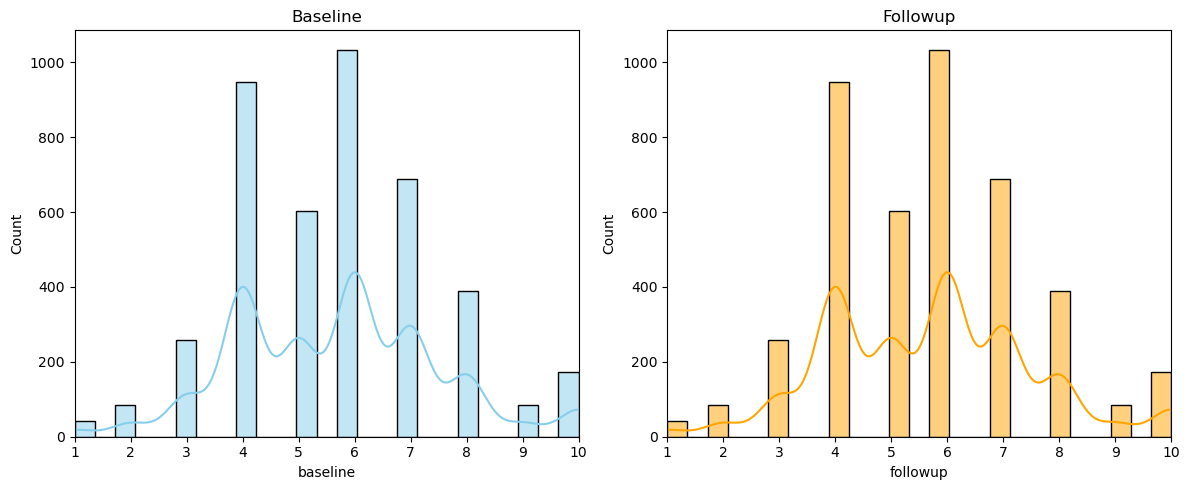

In [110]:
# Your existing code to create histograms.
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df['baseline'], ax=axs[0], color='skyblue', kde=True).set_title('Baseline')
sns.histplot(df['followup'], ax=axs[1], color='orange', kde=True).set_title('Followup')

# Set x-ticks to display every integer from 1 to 10.
axs[0].set_xticks(range(1, 11))
axs[1].set_xticks(range(1, 11))

# Optionally, you can also ensure that x-axis limits include the full range from 1 to 10
axs[0].set_xlim(1, 10)
axs[1].set_xlim(1, 10)

plt.tight_layout()
plt.show()


{'min': 0.0, 'max': 25.0, 'count': 43}
{'min': 25.0, 'max': 33.0, 'count': 86}
{'min': 34.0, 'max': 55.0, 'count': 259}
{'min': 55.0, 'max': 107.0, 'count': 947}
{'min': 107.0, 'max': 136.0, 'count': 604}
{'min': 136.0, 'max': 192.0, 'count': 1034}
{'min': 192.0, 'max': 246.0, 'count': 689}
{'min': 247.0, 'max': 297.0, 'count': 388}
{'min': 297.0, 'max': 318.0, 'count': 86}
{'min': 318.0, 'max': 580.0, 'count': 172}


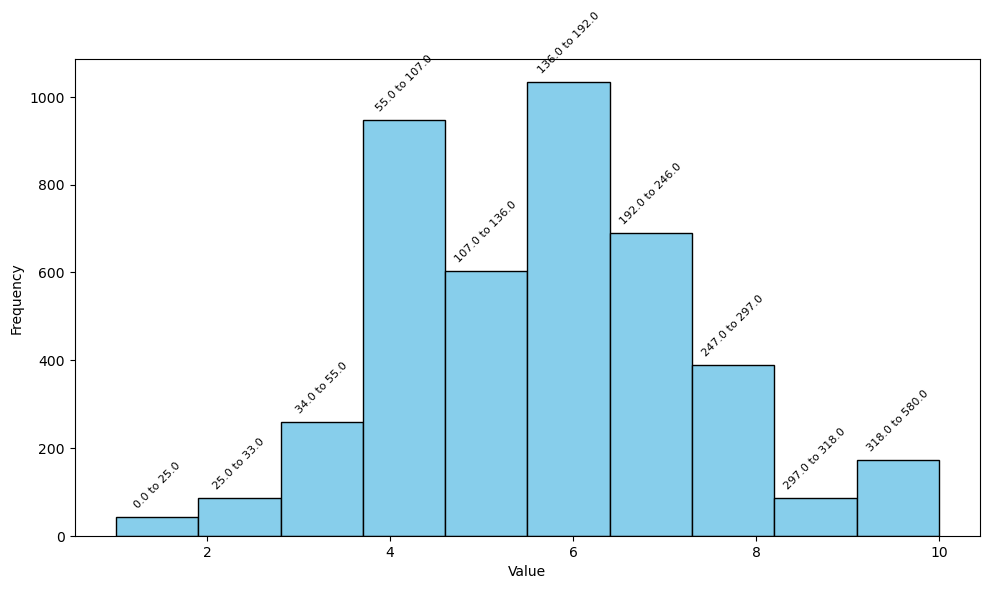

In [111]:
data = df

# Creating the histogram plot
fig, ax = plt.subplots(figsize=(10, 6))
counts, bins, patches = ax.hist(data.baseline, color='skyblue', edgecolor='black')

# Annotating each bin with the min and max value of that bin
for bin_left, bin_right, patch, cat_minmax in zip(bins, bins[1:], patches, category_min_max.values()):
    # Calculate the center of the bin for the x position of the annotation
    bin_center = (bin_left + bin_right) / 2
    # Prepare the annotation text as the range of the bin
    print(cat_minmax)
    annotation_text = f"{cat_minmax['min']:} to {cat_minmax['max']}"
    # Place the annotation above the bin (using the patch height for the y position)
    ax.annotate(annotation_text, xy=(bin_center, patch.get_height()), xytext=(0, 5), 
                textcoords='offset points', ha='center', va='bottom', fontsize=8, rotation=45)

# ax.set_title('Histogram with Annotated Bins (Min and Max Values)')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [112]:
df

,level_0,index,ID,V00BLDCOLL,V00BLDHRS1,V00BLDHRS2,V00BLDRAW1,V00BLDRAW2,V00BLSURD1,V00BLSURD2,...,V08IMAGESG,V10IMAGESA,V10IMAGESB,V10IMAGESC,V10IMAGESD,V10IMAGESE,V10IMAGESF,V10IMAGESG,baseline,followup
0,0,327,b'9083500',1.0,33000.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1,1
1,92,620,b'9164114',1.0,33000.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,2,1
2,143,4283,b'9993846',1.0,28320.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,3,1
3,3115,260,b'9066155',1.0,35400.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,7,1
4,15,753,b'9202047',1.0,35700.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,4263,2160,b'9521956',1.0,28440.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10,10
4304,4218,1747,b'9438852',1.0,31980.0,NaN,1.0,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,1.0,0.0,1.0,10,10
4305,2617,2295,b'9549405',1.0,38040.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6,10
4306,4287,3856,b'9894047',1.0,27420.0,NaN,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10,10


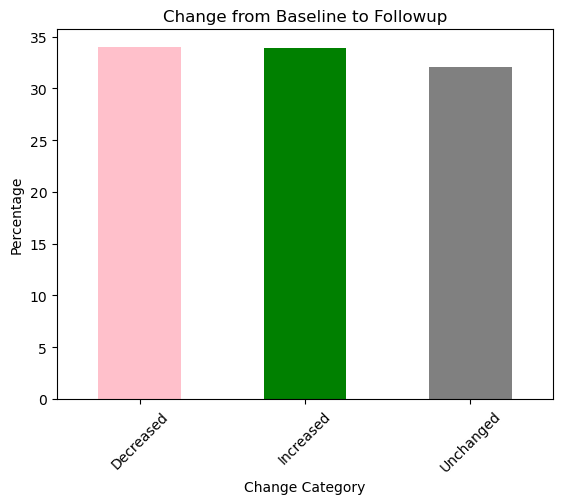

In [113]:
# Convert 'baseline' and 'followup' to numerical values
df['baseline'] = pd.to_numeric(df['baseline'], errors='coerce')
df['followup'] = pd.to_numeric(df['followup'], errors='coerce')

# Calculate the difference
df['change'] = df['followup'] - df['baseline']

# Define the function to categorize changes
def categorize_change(change):
    if change > 0:
        return 'Increased'
    elif change < 0:
        return 'Decreased'
    else:
        return 'Unchanged'

# Apply the function to categorize changes
df['change_category'] = df['change'].apply(categorize_change)

# Calculate percentages
change_percentages = df['change_category'].value_counts(normalize=True) * 100

# Plot
change_percentages.plot(kind='bar', color=['pink', 'green', 'gray'])
plt.title('Change from Baseline to Followup')
plt.xlabel('Change Category')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()


In [114]:
# Convert 'baseline' and 'followup' to numeric
df['baseline'] = pd.to_numeric(df['baseline'], errors='coerce')
df['followup'] = pd.to_numeric(df['followup'], errors='coerce')

# Calculate the difference
df['change'] = df['followup'] - df['baseline']

# Categorize the changes
def categorize_change(change):
    if change > 0:
        return 'Increased'
    elif change < 0:
        return 'Decreased'
    else:
        return 'Unchanged'

df['change_category'] = df['change'].apply(categorize_change)

# Count how many cases are in each category
change_counts = df['change_category'].value_counts()

# Display the counts
print(change_counts)

# If you wish to calculate percentages
change_percentages = df['change_category'].value_counts(normalize=True) * 100
print(change_percentages)


change_category
Decreased    1465
Increased    1462
Unchanged    1381
Name: count, dtype: int64
change_category
Decreased    34.006500
Increased    33.936862
Unchanged    32.056639
Name: proportion, dtype: float64
